### Import

In [230]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import math
from collections import Counter

### Data Prep

In [172]:
df = pd.read_csv('./data/Names.csv')

df.sample(5)

,English,Russian
6177,Kortney,Кортни
4819,Roslyn,Розлин
1308,Miner,Майнер
4580,Pricilla,Присцилла
6244,Audrianna,Одрианна


In [173]:
SPECIAL_TOKENS = ["<PAD>", "<SOS>", "<EOS>"]

def build_vocab(series, special_tokens=SPECIAL_TOKENS):
    chars = sorted(set(''.join(series).lower()))
    tokens = special_tokens + chars
    token2id = {ch: idx for idx, ch in enumerate(tokens)}
    id2token = {idx: ch for ch, idx in token2id.items()}
    vocab_size = len(token2id)
    pad_idx = token2id["<PAD>"]
    sos_idx = token2id["<SOS>"]
    eos_idx = token2id["<EOS>"]
    return {
        "tokens": tokens,
        "token2id": token2id,
        "id2token": id2token,
        "vocab_size": vocab_size,
        "pad_idx": pad_idx,
        "sos_idx": sos_idx,
        "eos_idx": eos_idx,
    }

In [174]:
eng_vocab = build_vocab(df['English'])

EN_TOKEN2ID = eng_vocab["token2id"]
EN_ID2TOKEN = eng_vocab["id2token"]
EN_VOCAB_SIZE = eng_vocab["vocab_size"]
EN_PAD_IDX = eng_vocab["pad_idx"]
EN_SOS_IDX = eng_vocab["sos_idx"]
EN_EOS_IDX = eng_vocab["eos_idx"]

ru_vocab = build_vocab(df['Russian'])

RU_TOKEN2ID = ru_vocab["token2id"]
RU_ID2TOKEN = ru_vocab["id2token"]
RU_VOCAB_SIZE = ru_vocab["vocab_size"]
RU_PAD_IDX = ru_vocab["pad_idx"]
RU_SOS_IDX = ru_vocab["sos_idx"]
RU_EOS_IDX = ru_vocab["eos_idx"]

In [175]:
def process_and_encode_names(series, token2id, pad_token="<PAD>", sos_token="<SOS>", eos_token="<EOS>"):
    processed = series.apply(lambda x: [sos_token] + list(x.lower()) + [eos_token])
    max_len = processed.apply(len).max()
    padded = processed.apply(lambda seq: seq + [pad_token] * (max_len - len(seq)))
    encoded = padded.apply(lambda seq: [token2id[ch] for ch in seq])
    return encoded, max_len

In [176]:
df['EnEncoded'], MAX_EN_LEN = process_and_encode_names(df['English'], EN_TOKEN2ID)
df['RuEncoded'], MAX_RU_LEN = process_and_encode_names(df['Russian'], RU_TOKEN2ID)

In [177]:
df.sample(5)

,English,Russian,EnEncoded,RuEncoded
3355,Malaki,Малаки,"[1, 15, 3, 14, 3, 13, 11, 2, 0, 0, 0, 0, 0]","[1, 15, 3, 14, 3, 13, 11, 2, 0, 0, 0, 0, 0, 0]"
31,Benjamin,Бенджамин,"[1, 4, 7, 16, 12, 3, 15, 11, 16, 2, 0, 0, 0]","[1, 4, 8, 16, 7, 9, 3, 15, 11, 16, 2, 0, 0, 0]"
1294,Greene,Грин,"[1, 9, 20, 7, 7, 16, 7, 2, 0, 0, 0, 0, 0]","[1, 6, 19, 11, 16, 2, 0, 0, 0, 0, 0, 0, 0, 0]"
6326,Hailee,Хейли,"[1, 10, 3, 11, 14, 7, 7, 2, 0, 0, 0, 0, 0]","[1, 24, 8, 12, 14, 11, 2, 0, 0, 0, 0, 0, 0, 0]"
4590,Louisiana,Луизиана,"[1, 14, 17, 23, 11, 21, 11, 3, 16, 3, 2, 0, 0]","[1, 14, 22, 11, 10, 11, 3, 16, 3, 2, 0, 0, 0, 0]"


In [178]:
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
valid_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

print(f"Train size: {len(train_df)}")
print(f"Valid size: {len(valid_df)}")
print(f"Test size: {len(test_df)}")

Train size: 5428
Valid size: 679
Test size: 679


### Support Functions

In [179]:
class EarlyStopping:
  def __init__(self, patience=5, min_delta=0):
    self.patience = patience
    self.min_delta = min_delta
    self.best_loss = np.inf
    self.counter = 0
    self.early_stop = False

  def __call__(self, val_loss):
    if val_loss < self.best_loss - self.min_delta:
      self.best_loss = val_loss
      self.counter = 0
    else:
      self.counter += 1
      if self.counter >= self.patience:
        self.early_stop = True

In [180]:
def train_encoder_epoch(model, dataloader, criterion, optimizer):
  model.train()
  total_loss = 0
  for x, y in dataloader:
    x, y = x.to(device), y.to(device)
    optimizer.zero_grad()
    logits, _, _ = model(x)
    loss = criterion(logits.reshape(-1, logits.size(-1)), y.reshape(-1))
    loss.backward()
    optimizer.step()
    total_loss += loss.item() * x.size(0)
  return total_loss / len(dataloader.dataset)

def eval_encoder_epoch(model, dataloader, criterion):
  model.eval()
  total_loss = 0
  with torch.no_grad():
    for x, y in dataloader:
      x, y = x.to(device), y.to(device)
      logits, _, _ = model(x)
      loss = criterion(logits.reshape(-1, logits.size(-1)), y.reshape(-1))
      total_loss += loss.item() * x.size(0)
  return total_loss / len(dataloader.dataset)

In [181]:
def generate_name(model, start_token_idx, end_token_idx, max_len=20, temperature=1.0):
  model.eval()
  name = [start_token_idx]
  input_seq = torch.tensor([start_token_idx], device=device).unsqueeze(0)

  with torch.no_grad():
    hidden = None
    for _ in range(max_len):
      logits, _, _ = model(input_seq)
      logits = logits[:, -1, :] / temperature
      probs = torch.softmax(logits, dim=-1)
      next_token = torch.multinomial(probs, num_samples=1).item()

      if next_token == end_token_idx:
          break

      name.append(next_token)
      input_seq = torch.tensor(name, device=device).unsqueeze(0)

    return "".join(EN_ID2TOKEN[idx] for idx in name[1:])

In [182]:
def train_translation_epoch(encoder, decoder, dataloader, criterion, optimizer, use_attention=False):
    decoder.train()
    total_loss = 0

    for src_batch, tgt_batch in dataloader:
        src_batch, tgt_batch = src_batch.to(device), tgt_batch.to(device)
        tgt_inp = tgt_batch[:, :-1] # decoder input
        tgt_out = tgt_batch[:, 1:]  # expected output

        with torch.no_grad():
          if use_attention:
              _, hidden, encoder_outputs = encoder(src_batch)
          else:
              _, hidden, _ = encoder(src_batch)

        optimizer.zero_grad()

        if use_attention:
            logits, hidden, _ = decoder(tgt_inp, encoder_outputs, hidden)
        else:
            logits, _ = decoder(tgt_inp, hidden)

        loss = criterion(logits.view(-1, logits.size(-1)), tgt_out.reshape(-1))
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * src_batch.size(0)

    return total_loss / len(dataloader.dataset)

def eval_translation_epoch(encoder, decoder, dataloader, criterion, use_attention=False):
    decoder.eval()
    total_loss = 0

    with torch.no_grad():
      for src_batch, tgt_batch in dataloader:
        src_batch, tgt_batch = src_batch.to(device), tgt_batch.to(device)
        tgt_inp = tgt_batch[:, :-1]
        tgt_out = tgt_batch[:, 1:]

        if use_attention:
            _, hidden, encoder_outputs = encoder(src_batch)
            logits, hidden, _ = decoder(tgt_inp, encoder_outputs, hidden)
        else:
            _, hidden, _ = encoder(src_batch)
            logits, hidden = decoder(tgt_inp, hidden)

        loss = criterion(logits.view(-1, logits.size(-1)), tgt_out.reshape(-1))
        total_loss += loss.item() * src_batch.size(0)

    avg_loss = total_loss / len(dataloader.dataset)
    return avg_loss

In [183]:
def plot_loss_curves(train_losses, valid_losses, title):
  plt.plot(train_losses, label='Train')
  plt.plot(valid_losses, label='Valid')
  plt.title(f"Loss Convergence {title}")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend()
  plt.grid()
  plt.show()

In [184]:
def translate_name(encoder, decoder, src_seq, max_len=20, use_attention=False):
  encoder.eval()
  decoder.eval()

  src_tensor = torch.tensor([src_seq], dtype=torch.long).to(device)

  with torch.no_grad():
    if use_attention:
      _, hidden, encoder_outputs = encoder(src_tensor)
    else:
      _, hidden, _ = encoder(src_tensor)
      encoder_outputs = None

  output_tokens = [RU_SOS_IDX]

  for _ in range(max_len):
    y_input = torch.tensor([output_tokens[-1]], dtype=torch.long).unsqueeze(0).to(device)

    if use_attention:
      logits, hidden, _ = decoder(y_input, encoder_outputs, hidden)  # unpack 3 outputs here
    else:
      logits, hidden = decoder(y_input, hidden)  # 2 outputs in non-attention decoder

    next_token = logits.argmax(dim=-1).item()

    if next_token == RU_EOS_IDX:
      break

    output_tokens.append(next_token)

  return ''.join(RU_ID2TOKEN[idx] for idx in output_tokens[1:])

def print_sample_translations(df, encoder, decoder, name="Sample", n=5, use_attention=False):
    print(f"\n{name} Sample Translations:")
    samples = df.sample(n)

    for _, row in samples.iterrows():
      en = row['English']
      ru_true = row['Russian']
      en_encoded = row['EnEncoded']
      ru_pred = translate_name(encoder, decoder, en_encoded, use_attention=use_attention)
      print(f"{en} → {ru_pred.capitalize()} (true: {ru_true})")

In [185]:
def evaluate_test_perplexity(encoder, decoder, test_loader, criterion, use_attention=False):
    test_loss = eval_translation_epoch(encoder, decoder, test_loader, criterion, use_attention=use_attention)
    perplexity = torch.exp(torch.tensor(test_loss)).item()
    print(f"Test Loss: {test_loss:.4f} | Perplexity: {perplexity:.2f}")

In [186]:
def plot_attention_heads(attn_weights, input_tokens, output_tokens, epoch, step, title="Multi-Head Attention", n_cols=3):
    """
    Visualize attention weights from multiple heads for a single example.
    """
    attn = attn_weights[0].detach().cpu().numpy()  # (n_heads, T_dec, T_enc)
    n_heads = attn.shape[0]
    n_rows = math.ceil(n_heads / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*4.5, n_rows*4))
    axes = np.array(axes).flatten()

    for i in range(n_heads):
        sns.heatmap(
            attn[i], ax=axes[i], cmap='viridis', cbar=False,
            xticklabels=input_tokens, yticklabels=output_tokens,
            square=True, linewidths=0.3, linecolor='gray'
        )
        axes[i].set_title(f"{title} - Head {i+1}\nEpoch {epoch}, Step {step}", fontsize=10)
        axes[i].tick_params(axis='x', rotation=45)
        axes[i].tick_params(axis='y', rotation=0)

    # Turn off any extra subplots
    for j in range(n_heads, n_rows * n_cols):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

In [187]:
def indices_to_tokens(indices, id2token):
    tokens = []
    for idx in indices:
        token = id2token.get(idx.item())
        if token is None:
            print(f"Warning: idx {idx.item()} not in id2token dict")
            token = "<unk>"
        tokens.append(token)
    if "<eos>" in tokens:
        tokens = tokens[:tokens.index("<eos>") + 1]
    return tokens

In [212]:
def train_mha_model(
    encoder, decoder, train_loader, valid_loader,
    criterion, optimizer, early_stopping,
    src_id2token, tgt_id2token,
    n_epochs=100, n_plot_epochs=15, name="Multi-Head Attention",
    fixed_plot_loader=None, plot_sample_index=0, attention_plot_fn=plot_attention_heads):

    encoder.eval()
    decoder.train()

    train_losses = []
    valid_losses = []

    for epoch in range(1, n_epochs + 1):
        train_loss = train_translation_epoch(encoder, decoder, train_loader, criterion, optimizer, use_attention=True)
        valid_loss = eval_translation_epoch(encoder, decoder, valid_loader, criterion, use_attention=True)

        train_losses.append(train_loss)
        valid_losses.append(valid_loss)

        if epoch % n_plot_epochs == 0 and fixed_plot_loader is not None:
            src_batch, tgt_batch = next(iter(fixed_plot_loader))
            src_batch, tgt_batch = src_batch.to(device), tgt_batch.to(device)
            tgt_inp = tgt_batch[:, :-1]

            with torch.no_grad():
                _, hidden, encoder_outputs = encoder(src_batch)
                _, _, attn_weights = decoder(tgt_inp, encoder_outputs, hidden)

            attention_plot_fn(
                attn_weights,
                input_tokens=indices_to_tokens(src_batch[plot_sample_index], src_id2token),
                output_tokens=indices_to_tokens(tgt_inp[plot_sample_index], tgt_id2token),
                epoch=epoch,
                step=0,
                title=name
            )

        early_stopping(valid_loss)
        if early_stopping.early_stop:
            print(f"Early stopping triggered at epoch {epoch}")
            break

    return train_losses, valid_losses

### RNN Encoder

In [189]:
class RNNEncoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, pad_idx=None):
      super().__init__()
      self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
      self.gru = nn.GRU(embedding_dim, hidden_dim, batch_first=True)
      self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x):
      emb = self.embedding(x)
      out, hidden = self.gru(emb)
      logits = self.fc(out)
      return logits, hidden, out

In [190]:
class NameDataset(Dataset):
    def __init__(self, encoded_names):
        self.data = encoded_names

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        seq = torch.tensor(self.data[idx], dtype=torch.long)
        return seq[:-1], seq[1:]

train_ds = NameDataset(train_df['EnEncoded'].tolist())
valid_ds = NameDataset(valid_df['EnEncoded'].tolist())

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True)
valid_loader = DataLoader(valid_ds, batch_size=128)

In [191]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

rnn_encoder = RNNEncoder(EN_VOCAB_SIZE, embedding_dim=64, hidden_dim=128, pad_idx=EN_PAD_IDX).to(device)
encoder_criterion = nn.CrossEntropyLoss(ignore_index=EN_PAD_IDX)
encoder_optimizer = torch.optim.Adam(rnn_encoder.parameters(), lr=0.001)
encoder_early_stopping = EarlyStopping(patience=7, min_delta=0.001)

n_epochs = 100
for epoch in range(1, n_epochs + 1):
    train_loss = train_encoder_epoch(rnn_encoder, train_loader, encoder_criterion, encoder_optimizer)
    valid_loss = eval_encoder_epoch(rnn_encoder, valid_loader, encoder_criterion)
    print(f"Epoch {epoch} | Train loss: {train_loss:.4f} | Valid loss: {valid_loss:.4f}")
    encoder_early_stopping(valid_loss)
    if encoder_early_stopping.early_stop:
      print("Early stopping triggered.")
      break

Epoch 1 | Train loss: 2.7865 | Valid loss: 2.4645
Epoch 2 | Train loss: 2.3633 | Valid loss: 2.2864
Epoch 3 | Train loss: 2.2433 | Valid loss: 2.2162
Epoch 4 | Train loss: 2.1819 | Valid loss: 2.1725
Epoch 5 | Train loss: 2.1388 | Valid loss: 2.1438
Epoch 6 | Train loss: 2.1062 | Valid loss: 2.1154
Epoch 7 | Train loss: 2.0772 | Valid loss: 2.0976
Epoch 8 | Train loss: 2.0527 | Valid loss: 2.0791
Epoch 9 | Train loss: 2.0329 | Valid loss: 2.0677
Epoch 10 | Train loss: 2.0128 | Valid loss: 2.0510
Epoch 11 | Train loss: 1.9939 | Valid loss: 2.0424
Epoch 12 | Train loss: 1.9766 | Valid loss: 2.0276
Epoch 13 | Train loss: 1.9587 | Valid loss: 2.0217
Epoch 14 | Train loss: 1.9430 | Valid loss: 2.0116
Epoch 15 | Train loss: 1.9280 | Valid loss: 2.0017
Epoch 16 | Train loss: 1.9115 | Valid loss: 1.9948
Epoch 17 | Train loss: 1.8972 | Valid loss: 1.9890
Epoch 18 | Train loss: 1.8839 | Valid loss: 1.9788
Epoch 19 | Train loss: 1.8701 | Valid loss: 1.9763
Epoch 20 | Train loss: 1.8572 | Valid lo

In [200]:
for _ in range(10):
  print(generate_name(rnn_encoder, EN_SOS_IDX, EN_EOS_IDX, temperature=0.75).capitalize())

Ina
Branson
Coraine
Rosanna
Judy
Alayana
Landan
Mart
Signey
Malco


### RNN Machine Translation

The goal is to translate English names into Russian character-by-character using a trained RNN encoder and a new RNN decoder.

In [193]:
rnn_encoder.eval()
for param in rnn_encoder.parameters():
  param.requires_grad = False

In [194]:
class RNNDecoder(nn.Module):
  def __init__(self, vocab_size, embedding_dim, hidden_dim, pad_idx):
    super().__init__()
    self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
    self.gru = nn.GRU(embedding_dim, hidden_dim, batch_first=True)
    self.fc = nn.Linear(hidden_dim, vocab_size)

  def forward(self, y_input, hidden):
    embedded = self.embedding(y_input)
    output, hidden = self.gru(embedded, hidden) # hidden: from encoder
    logits = self.fc(output)
    return logits, hidden

In [195]:
class NameTranslationDataset(Dataset):
    def __init__(self, src_encoded, tgt_encoded):
      self.data = list(zip(src_encoded, tgt_encoded))

    def __len__(self):
      return len(self.data)

    def __getitem__(self, idx):
      src, tgt = self.data[idx]
      eng = torch.tensor(src, dtype=torch.long)
      rus = torch.tensor(tgt, dtype=torch.long)
      return eng, rus

train_ds = NameTranslationDataset(train_df['EnEncoded'].tolist(), train_df['RuEncoded'].tolist())
valid_ds = NameTranslationDataset(valid_df['EnEncoded'].tolist(), valid_df['RuEncoded'].tolist())
test_ds = NameTranslationDataset(test_df['EnEncoded'].tolist(), test_df['RuEncoded'].tolist())

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True)
valid_loader = DataLoader(valid_ds, batch_size=128)
test_loader = DataLoader(test_ds, batch_size=128)

In [196]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

rnn_decoder = RNNDecoder(RU_VOCAB_SIZE, embedding_dim=64, hidden_dim=128, pad_idx=RU_PAD_IDX).to(device)
decoder_criterion = nn.CrossEntropyLoss(ignore_index=RU_PAD_IDX)
decoder_optimizer = torch.optim.Adam(rnn_decoder.parameters(), lr=0.001)
decoder_early_stopping = EarlyStopping(patience=5, min_delta=0.001)

n_epochs = 100
train_losses, valid_losses = [], []

for epoch in range(1, n_epochs + 1):
    train_loss = train_translation_epoch(rnn_encoder, rnn_decoder, train_loader, decoder_criterion, decoder_optimizer)
    valid_loss = eval_translation_epoch(rnn_encoder, rnn_decoder, valid_loader, decoder_criterion)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    print(f"Epoch {epoch} | Train loss: {train_loss:.4f} | Valid loss: {valid_loss:.4f}")

    decoder_early_stopping(valid_loss)
    if decoder_early_stopping.early_stop:
        print("Early stopping triggered.")
        break

Epoch 1 | Train loss: 2.8111 | Valid loss: 2.4767
Epoch 2 | Train loss: 2.3452 | Valid loss: 2.2497
Epoch 3 | Train loss: 2.1937 | Valid loss: 2.1487
Epoch 4 | Train loss: 2.1024 | Valid loss: 2.0801
Epoch 5 | Train loss: 2.0366 | Valid loss: 2.0252
Epoch 6 | Train loss: 1.9839 | Valid loss: 1.9844
Epoch 7 | Train loss: 1.9377 | Valid loss: 1.9469
Epoch 8 | Train loss: 1.8944 | Valid loss: 1.9186
Epoch 9 | Train loss: 1.8554 | Valid loss: 1.8833
Epoch 10 | Train loss: 1.8168 | Valid loss: 1.8471
Epoch 11 | Train loss: 1.7819 | Valid loss: 1.8159
Epoch 12 | Train loss: 1.7470 | Valid loss: 1.7995
Epoch 13 | Train loss: 1.7190 | Valid loss: 1.7761
Epoch 14 | Train loss: 1.6917 | Valid loss: 1.7590
Epoch 15 | Train loss: 1.6686 | Valid loss: 1.7399
Epoch 16 | Train loss: 1.6447 | Valid loss: 1.7277
Epoch 17 | Train loss: 1.6190 | Valid loss: 1.7104
Epoch 18 | Train loss: 1.6004 | Valid loss: 1.7011
Epoch 19 | Train loss: 1.5794 | Valid loss: 1.6834
Epoch 20 | Train loss: 1.5603 | Valid lo

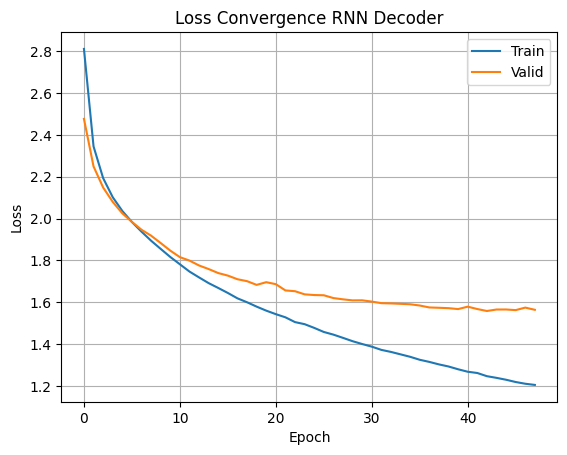

In [197]:
plot_loss_curves(train_losses, valid_losses, title='RNN Decoder')

In [198]:
print_sample_translations(train_df, rnn_encoder, rnn_decoder, name="Train (No Attention)", use_attention=False)
print_sample_translations(valid_df, rnn_encoder, rnn_decoder, name="Valid (No Attention)", use_attention=False)


Train (No Attention) Sample Translations:
Tamala → Татана (true: Тамала)
Durell → Кирлел (true: Дюрелл)
Fletcher → Даррелл (true: Флетчер)
Gwenda → Джамара (true: Гвэнда)
Carlota → Катальда (true: Карлота)

Valid (No Attention) Sample Translations:
Myrtie → Линдиан (true: Мирти)
Marci → Мари (true: Марси)
Effa → Карло (true: Эффа)
Lovina → Лаверия (true: Ловина)
Ama → Тай (true: Ама)


In [199]:
evaluate_test_perplexity(rnn_encoder, rnn_decoder, test_loader, decoder_criterion, use_attention=False)

Test Loss: 1.6094 | Perplexity: 5.00


### Attention Machine Translation

In [202]:
rnn_encoder.eval()
for param in rnn_encoder.parameters():
  param.requires_grad = False

In [203]:
class AttentionDecoder(nn.Module):
  def __init__(self, vocab_size, embedding_dim, hidden_dim, pad_idx):
    super().__init__()
    self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
    self.gru = nn.GRU(embedding_dim + hidden_dim, hidden_dim, batch_first=True)
    self.fc = nn.Linear(hidden_dim, vocab_size)

  def compute_attention(self, decoder_hidden, encoder_outputs, mask=None):
    query = decoder_hidden.transpose(0, 1) # (1, B, H) → (B, 1, H)
    attn_scores = torch.bmm(query, encoder_outputs.transpose(1, 2)) # (B, 1, T)
    if mask is not None:
      attn_scores = attn_scores.masked_fill(mask.unsqueeze(1) == 0, -1e9)
    attn_weights = torch.softmax(attn_scores, dim=-1)  # (B, 1, T)
    context = torch.bmm(attn_weights, encoder_outputs)  # (B, 1, H)
    return context, attn_weights

  def forward(self, y_input, encoder_outputs, hidden, src_mask=None):
    B, T = y_input.size()
    embedded = self.embedding(y_input)  # (B, T, E)

    outputs = []
    for t in range(T):
      y_t = embedded[:, t:t+1, :]  # (B, 1, E)
      context, attn_weights = self.compute_attention(hidden, encoder_outputs, mask=src_mask)  # (B, 1, H)
      rnn_input = torch.cat([y_t, context], dim=-1)  # (B, 1, E+H)
      output, hidden = self.gru(rnn_input, hidden)  # (B, 1, H)
      logits = self.fc(output)  # (B, 1, V)
      outputs.append(logits)

    return torch.cat(outputs, dim=1), hidden, attn_weights # (B, T, V), _, _

In [204]:
attention_decoder = AttentionDecoder(RU_VOCAB_SIZE, 64, 128, RU_PAD_IDX).to(device)
attention_optimizer = torch.optim.Adam(attention_decoder.parameters(), lr=0.001)
attention_criterion = nn.CrossEntropyLoss(ignore_index=RU_PAD_IDX)
early_stopping = EarlyStopping(patience=7, min_delta=0.001)

n_epochs = 100
train_losses, valid_losses = [], []

for epoch in range(1, n_epochs + 1):
    train_loss = train_translation_epoch(rnn_encoder, attention_decoder, train_loader, attention_criterion, attention_optimizer, use_attention=True)
    valid_loss = eval_translation_epoch(rnn_encoder, attention_decoder, valid_loader, attention_criterion, use_attention=True)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    print(f"[Attention] Epoch {epoch} | Train Loss: {train_loss:.4f} | Valid Loss: {valid_loss:.4f}")

    early_stopping(valid_loss)
    if early_stopping.early_stop:
        print("Early stopping triggered.")
        break

[Attention] Epoch 1 | Train Loss: 2.7279 | Valid Loss: 2.4348
[Attention] Epoch 2 | Train Loss: 2.2800 | Valid Loss: 2.1605
[Attention] Epoch 3 | Train Loss: 2.0809 | Valid Loss: 2.0254
[Attention] Epoch 4 | Train Loss: 1.9651 | Valid Loss: 1.9398
[Attention] Epoch 5 | Train Loss: 1.8802 | Valid Loss: 1.8803
[Attention] Epoch 6 | Train Loss: 1.8064 | Valid Loss: 1.8070
[Attention] Epoch 7 | Train Loss: 1.7428 | Valid Loss: 1.7639
[Attention] Epoch 8 | Train Loss: 1.6947 | Valid Loss: 1.7318
[Attention] Epoch 9 | Train Loss: 1.6368 | Valid Loss: 1.6797
[Attention] Epoch 10 | Train Loss: 1.5800 | Valid Loss: 1.6235
[Attention] Epoch 11 | Train Loss: 1.5172 | Valid Loss: 1.5618
[Attention] Epoch 12 | Train Loss: 1.4462 | Valid Loss: 1.5086
[Attention] Epoch 13 | Train Loss: 1.3799 | Valid Loss: 1.4558
[Attention] Epoch 14 | Train Loss: 1.3167 | Valid Loss: 1.4021
[Attention] Epoch 15 | Train Loss: 1.2627 | Valid Loss: 1.3689
[Attention] Epoch 16 | Train Loss: 1.2126 | Valid Loss: 1.3369
[

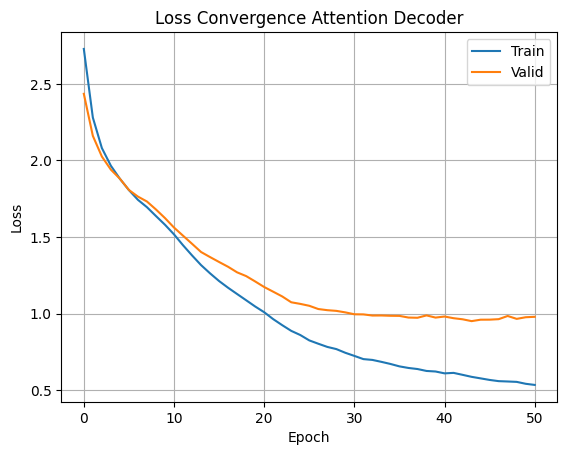

In [205]:
plot_loss_curves(train_losses, valid_losses, title='Attention Decoder')

In [206]:
print_sample_translations(train_df, rnn_encoder, attention_decoder, name="Train (Attention)", use_attention=True)
print_sample_translations(valid_df, rnn_encoder, attention_decoder, name="Valid (Attention)", use_attention=True)


Train (Attention) Sample Translations:
Jaylen → Джейлен (true: Джейлен)
Gustaf → Джастефо (true: Густав)
Wilford → Ролфур (true: Уилфорд)
Miller → Риллер (true: Миллер)
Shannen → Шаннен (true: Шаннен)

Valid (Attention) Sample Translations:
Tella → Телла (true: Телла)
Kyara → Джайра (true: Кьяра)
Rella → Релла (true: Релла)
Janae → Джани (true: Джанае)
Gabriella → Мабрилела (true: Габриэлла)


In [207]:
evaluate_test_perplexity(rnn_encoder, attention_decoder, test_loader, decoder_criterion, use_attention=True)

Test Loss: 1.0135 | Perplexity: 2.76


### Positional Encoding

In [40]:
name_train_ds = NameDataset(train_df['EnEncoded'].tolist())
name_valid_ds = NameDataset(valid_df['EnEncoded'].tolist())

name_train_loader = DataLoader(name_train_ds, batch_size=128, shuffle=True)
name_valid_loader = DataLoader(name_valid_ds, batch_size=128)

In [108]:
def get_positional_encoding(max_len, d_model):
  pos_encoding = torch.zeros(max_len, d_model)
  positions = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
  div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

  pos_encoding[:, 0::2] = torch.sin(positions * div_term)
  pos_encoding[:, 1::2] = torch.cos(positions * div_term)
  return pos_encoding

In [109]:
class PositionalRNNEncoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, pad_idx, max_len=100):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        self.dropout = nn.Dropout(0.3)
        self.register_buffer('positional_encoding', get_positional_encoding(max_len, embedding_dim).unsqueeze(0))
        self.gru = nn.GRU(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x):
        B, T = x.shape
        embedded = self.dropout(self.embedding(x))
        pe = self.positional_encoding[:, :T, :].to(x.device)
        x = embedded + pe
        out, hidden = self.gru(x)
        logits = self.fc(out)
        return logits, hidden, out

In [110]:
p_rnn_encoder = PositionalRNNEncoder(EN_VOCAB_SIZE, 64, 96, EN_PAD_IDX, MAX_EN_LEN).to(device)
optimizer = torch.optim.Adam(p_rnn_encoder.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(ignore_index=EN_PAD_IDX)
early_stopping = EarlyStopping(patience=5)

for epoch in range(1, 101):
  train_loss = train_encoder_epoch(p_rnn_encoder, name_train_loader, criterion, optimizer)
  valid_loss = eval_encoder_epoch(p_rnn_encoder, name_valid_loader, criterion)
  print(f"[PosEn] Epoch {epoch} | Train loss: {train_loss:.4f} | Valid loss: {valid_loss:.4f}")
  early_stopping(valid_loss)
  if early_stopping.early_stop:
      print("Early stopping encoder training")
      break

[PosEn] Epoch 1 | Train loss: 2.8116 | Valid loss: 2.5370
[PosEn] Epoch 2 | Train loss: 2.4666 | Valid loss: 2.3666
[PosEn] Epoch 3 | Train loss: 2.3394 | Valid loss: 2.2794
[PosEn] Epoch 4 | Train loss: 2.2722 | Valid loss: 2.2271
[PosEn] Epoch 5 | Train loss: 2.2269 | Valid loss: 2.1948
[PosEn] Epoch 6 | Train loss: 2.1954 | Valid loss: 2.1677
[PosEn] Epoch 7 | Train loss: 2.1675 | Valid loss: 2.1474
[PosEn] Epoch 8 | Train loss: 2.1459 | Valid loss: 2.1325
[PosEn] Epoch 9 | Train loss: 2.1279 | Valid loss: 2.1197
[PosEn] Epoch 10 | Train loss: 2.1105 | Valid loss: 2.1061
[PosEn] Epoch 11 | Train loss: 2.0991 | Valid loss: 2.0980
[PosEn] Epoch 12 | Train loss: 2.0847 | Valid loss: 2.0874
[PosEn] Epoch 13 | Train loss: 2.0709 | Valid loss: 2.0788
[PosEn] Epoch 14 | Train loss: 2.0588 | Valid loss: 2.0771
[PosEn] Epoch 15 | Train loss: 2.0514 | Valid loss: 2.0675
[PosEn] Epoch 16 | Train loss: 2.0383 | Valid loss: 2.0570
[PosEn] Epoch 17 | Train loss: 2.0311 | Valid loss: 2.0535
[PosEn

In [ ]:
rnn_decoder = RNNDecoder(RU_VOCAB_SIZE, 64, 128, RU_PAD_IDX).to(device)
optimizer_rnn = torch.optim.Adam(rnn_decoder.parameters(), lr=0.001)
criterion_rnn = nn.CrossEntropyLoss(ignore_index=RU_PAD_IDX)
early_stopping_rnn = EarlyStopping(patience=5)

train_losses, valid_losses = [], []

for epoch in range(1, 101):
    train_loss = train_translation_epoch(p_rnn_encoder, rnn_decoder, train_loader, criterion_rnn, optimizer_rnn, use_attention=False)
    valid_loss = eval_translation_epoch(p_rnn_encoder, rnn_decoder, valid_loader, criterion_rnn, use_attention=False)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    print(f"[RNN] Epoch {epoch} | Train Loss: {train_loss:.4f} | Valid Loss: {valid_loss:.4f}")

    early_stopping_rnn(valid_loss)
    if early_stopping_rnn.early_stop:
        print("Early stopping (RNN Decoder)")
        break

[RNN] Epoch 1 | Train Loss: 2.8033 | Valid Loss: 2.4264
[RNN] Epoch 2 | Train Loss: 2.2858 | Valid Loss: 2.1812
[RNN] Epoch 3 | Train Loss: 2.1054 | Valid Loss: 2.0559
[RNN] Epoch 4 | Train Loss: 1.9947 | Valid Loss: 1.9648
[RNN] Epoch 5 | Train Loss: 1.9169 | Valid Loss: 1.8963
[RNN] Epoch 6 | Train Loss: 1.8535 | Valid Loss: 1.8442
[RNN] Epoch 7 | Train Loss: 1.8007 | Valid Loss: 1.7981
[RNN] Epoch 8 | Train Loss: 1.7493 | Valid Loss: 1.7534
[RNN] Epoch 9 | Train Loss: 1.7037 | Valid Loss: 1.7160
[RNN] Epoch 10 | Train Loss: 1.6634 | Valid Loss: 1.6863
[RNN] Epoch 11 | Train Loss: 1.6283 | Valid Loss: 1.6498
[RNN] Epoch 12 | Train Loss: 1.5939 | Valid Loss: 1.6305
[RNN] Epoch 13 | Train Loss: 1.5625 | Valid Loss: 1.6192
[RNN] Epoch 14 | Train Loss: 1.5348 | Valid Loss: 1.5777
[RNN] Epoch 15 | Train Loss: 1.5045 | Valid Loss: 1.5696
[RNN] Epoch 16 | Train Loss: 1.4831 | Valid Loss: 1.5457
[RNN] Epoch 17 | Train Loss: 1.4545 | Valid Loss: 1.5272
[RNN] Epoch 18 | Train Loss: 1.4287 | Va

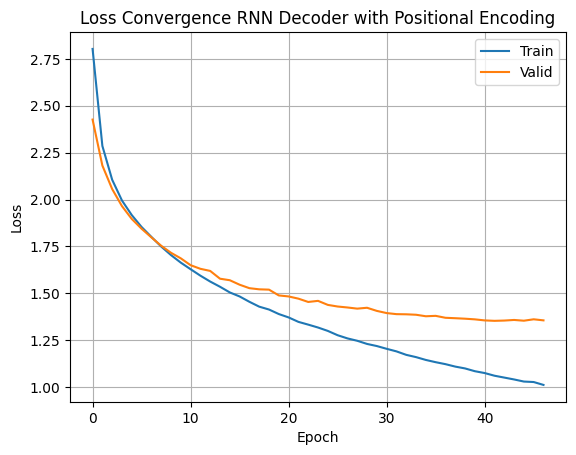

In [ ]:
plot_loss_curves(train_losses, valid_losses, title="RNN Decoder with Positional Encoding")

In [ ]:
print_sample_translations(train_df, p_rnn_encoder, rnn_decoder, use_attention=False, name="Train (RNN + PE)")
print_sample_translations(valid_df, p_rnn_encoder, rnn_decoder, use_attention=False, name="Valid (RNN + PE)")


Train (RNN + PE) Sample Translations:
Johnnie → Джонни (true: Джонни)
Henrietta → Кристиана (true: Генриетта)
Saint → Майка (true: Сэйнт)
Rhonda → Кариана (true: Ронда)
Enola → Нелия (true: Энола)

Valid (RNN + PE) Sample Translations:
Lucas → Клавер (true: Лукас)
Alvie → Альви (true: Алви)
Mayra → Майела (true: Майра)
Shameka → Макимара (true: Шамека)
Deacon → Джереди (true: Дикон)


In [ ]:
evaluate_test_perplexity(p_rnn_encoder, rnn_decoder, test_loader, criterion_rnn, use_attention=False)

Test Loss: 1.4465 | Perplexity: 4.25


In [ ]:
attn_decoder = AttentionDecoder(RU_VOCAB_SIZE, 64, 128, RU_PAD_IDX).to(device)
optimizer_attn = torch.optim.Adam(attn_decoder.parameters(), lr=0.001)
criterion_attn = nn.CrossEntropyLoss(ignore_index=RU_PAD_IDX)
early_stopping_attn = EarlyStopping(patience=5)

train_losses_attn, valid_losses_attn = [], []

for epoch in range(1, 101):
    train_loss = train_translation_epoch(p_rnn_encoder, attn_decoder, train_loader, criterion_attn, optimizer_attn, use_attention=True)
    valid_loss = eval_translation_epoch(p_rnn_encoder, attn_decoder, valid_loader, criterion_attn, use_attention=True)

    train_losses_attn.append(train_loss)
    valid_losses_attn.append(valid_loss)
    print(f"[Attention] Epoch {epoch} | Train Loss: {train_loss:.4f} | Valid Loss: {valid_loss:.4f}")

    early_stopping_attn(valid_loss)
    if early_stopping_attn.early_stop:
        print("Early stopping (Attention Decoder)")
        break

[Attention] Epoch 1 | Train Loss: 2.7218 | Valid Loss: 2.3988
[Attention] Epoch 2 | Train Loss: 2.2302 | Valid Loss: 2.0909
[Attention] Epoch 3 | Train Loss: 1.9877 | Valid Loss: 1.9143
[Attention] Epoch 4 | Train Loss: 1.8469 | Valid Loss: 1.8010
[Attention] Epoch 5 | Train Loss: 1.7530 | Valid Loss: 1.7237
[Attention] Epoch 6 | Train Loss: 1.6741 | Valid Loss: 1.6567
[Attention] Epoch 7 | Train Loss: 1.6068 | Valid Loss: 1.6024
[Attention] Epoch 8 | Train Loss: 1.5476 | Valid Loss: 1.5665
[Attention] Epoch 9 | Train Loss: 1.4980 | Valid Loss: 1.5142
[Attention] Epoch 10 | Train Loss: 1.4426 | Valid Loss: 1.4777
[Attention] Epoch 11 | Train Loss: 1.3973 | Valid Loss: 1.4376
[Attention] Epoch 12 | Train Loss: 1.3541 | Valid Loss: 1.3969
[Attention] Epoch 13 | Train Loss: 1.3111 | Valid Loss: 1.3730
[Attention] Epoch 14 | Train Loss: 1.2747 | Valid Loss: 1.3550
[Attention] Epoch 15 | Train Loss: 1.2394 | Valid Loss: 1.3230
[Attention] Epoch 16 | Train Loss: 1.2013 | Valid Loss: 1.2971
[

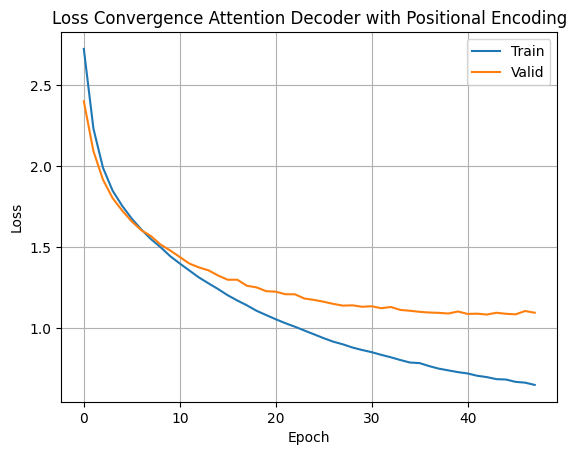

In [ ]:
plot_loss_curves(train_losses_attn, valid_losses_attn, title="Attention Decoder with Positional Encoding")

In [ ]:
print_sample_translations(train_df, p_rnn_encoder, attn_decoder, use_attention=True, name="Train (Attention + PE)")
print_sample_translations(valid_df, p_rnn_encoder, attn_decoder, use_attention=True, name="Valid (Attention + PE)")


Train (Attention + PE) Sample Translations:
Heaven → Кейвен (true: Хэвен)
Lue → Лу (true: Лу)
Tayla → Тайла (true: Тейла)
Christina → Кристина (true: Кристина)
Kiarra → Джаварда (true: Киарра)

Valid (Attention + PE) Sample Translations:
Karyl → Дерикл (true: Карил)
Zela → Сеола (true: Зела)
Jakobe → Джейми (true: Джейкоби)
Julius → Клайус (true: Джулиус)
Miracle → Розелл (true: Миракл)


In [ ]:
evaluate_test_perplexity(p_rnn_encoder, attn_decoder, test_loader, criterion_attn, use_attention=True)

Test Loss: 1.1497 | Perplexity: 3.16


In [56]:
class LearnablePositionalRNNEncoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, pad_idx, max_len=100, dropout=0.3):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        self.pos_embedding = nn.Embedding(max_len, embedding_dim)
        self.dropout = nn.Dropout(dropout)
        self.gru = nn.GRU(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x):
        B, T = x.size()
        token_emb = self.embedding(x)                        # (B, T, E)
        pos_ids = torch.arange(T, device=x.device).unsqueeze(0).expand(B, T)  # (B, T)
        pos_emb = self.pos_embedding(pos_ids)                # (B, T, E)
        x = token_emb + pos_emb                              # (B, T, E)
        x = self.dropout(x)
        out, hidden = self.gru(x)
        logits = self.fc(out)
        return logits, hidden, out

In [64]:
learn_p_rnn_encoder = LearnablePositionalRNNEncoder(EN_VOCAB_SIZE, 64, 96, EN_PAD_IDX, MAX_EN_LEN).to(device)
optimizer = torch.optim.Adam(learn_p_rnn_encoder.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(ignore_index=EN_PAD_IDX)
early_stopping = EarlyStopping(patience=5)

for epoch in range(1, 101):
    train_loss = train_encoder_epoch(learn_p_rnn_encoder, name_train_loader, criterion, optimizer)
    valid_loss = eval_encoder_epoch(learn_p_rnn_encoder, name_valid_loader, criterion)
    print(f"[Learnable PosEnc] Epoch {epoch} | Train loss: {train_loss:.4f} | Valid loss: {valid_loss:.4f}")
    early_stopping(valid_loss)
    if early_stopping.early_stop:
        print("Early stopping encoder training")
        break

[Learnable PosEnc] Epoch 1 | Train loss: 2.8209 | Valid loss: 2.5200
[Learnable PosEnc] Epoch 2 | Train loss: 2.4588 | Valid loss: 2.3666
[Learnable PosEnc] Epoch 3 | Train loss: 2.3561 | Valid loss: 2.2930
[Learnable PosEnc] Epoch 4 | Train loss: 2.2968 | Valid loss: 2.2445
[Learnable PosEnc] Epoch 5 | Train loss: 2.2531 | Valid loss: 2.2077
[Learnable PosEnc] Epoch 6 | Train loss: 2.2207 | Valid loss: 2.1825
[Learnable PosEnc] Epoch 7 | Train loss: 2.1974 | Valid loss: 2.1624
[Learnable PosEnc] Epoch 8 | Train loss: 2.1733 | Valid loss: 2.1450
[Learnable PosEnc] Epoch 9 | Train loss: 2.1600 | Valid loss: 2.1312
[Learnable PosEnc] Epoch 10 | Train loss: 2.1412 | Valid loss: 2.1231
[Learnable PosEnc] Epoch 11 | Train loss: 2.1257 | Valid loss: 2.1122
[Learnable PosEnc] Epoch 12 | Train loss: 2.1112 | Valid loss: 2.0982
[Learnable PosEnc] Epoch 13 | Train loss: 2.1000 | Valid loss: 2.0885
[Learnable PosEnc] Epoch 14 | Train loss: 2.0878 | Valid loss: 2.0862
[Learnable PosEnc] Epoch 15 |

In [ ]:
rnn_decoder = RNNDecoder(RU_VOCAB_SIZE, 64, 128, RU_PAD_IDX).to(device)
optimizer_rnn = torch.optim.Adam(rnn_decoder.parameters(), lr=0.001)
criterion_rnn = nn.CrossEntropyLoss(ignore_index=RU_PAD_IDX)
early_stopping_rnn = EarlyStopping(patience=5)

train_losses, valid_losses = [], []

for epoch in range(1, 101):
    train_loss = train_translation_epoch(learn_p_rnn_encoder, rnn_decoder, train_loader, criterion_rnn, optimizer_rnn, use_attention=False)
    valid_loss = eval_translation_epoch(learn_p_rnn_encoder, rnn_decoder, valid_loader, criterion_rnn, use_attention=False)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    print(f"[RNN + Learnable PE] Epoch {epoch} | Train Loss: {train_loss:.4f} | Valid Loss: {valid_loss:.4f}")

    early_stopping_rnn(valid_loss)
    if early_stopping_rnn.early_stop:
        print("Early stopping (RNN Decoder)")
        break

[RNN] Epoch 1 | Train Loss: 2.8156 | Valid Loss: 2.4670
[RNN] Epoch 2 | Train Loss: 2.3272 | Valid Loss: 2.2348
[RNN] Epoch 3 | Train Loss: 2.1734 | Valid Loss: 2.1365
[RNN] Epoch 4 | Train Loss: 2.0920 | Valid Loss: 2.0723
[RNN] Epoch 5 | Train Loss: 2.0263 | Valid Loss: 2.0196
[RNN] Epoch 6 | Train Loss: 1.9646 | Valid Loss: 1.9694
[RNN] Epoch 7 | Train Loss: 1.9034 | Valid Loss: 1.9011
[RNN] Epoch 8 | Train Loss: 1.8417 | Valid Loss: 1.8497
[RNN] Epoch 9 | Train Loss: 1.7858 | Valid Loss: 1.8332
[RNN] Epoch 10 | Train Loss: 1.7402 | Valid Loss: 1.7765
[RNN] Epoch 11 | Train Loss: 1.6944 | Valid Loss: 1.7378
[RNN] Epoch 12 | Train Loss: 1.6584 | Valid Loss: 1.7174
[RNN] Epoch 13 | Train Loss: 1.6259 | Valid Loss: 1.6881
[RNN] Epoch 14 | Train Loss: 1.5934 | Valid Loss: 1.6640
[RNN] Epoch 15 | Train Loss: 1.5683 | Valid Loss: 1.6434
[RNN] Epoch 16 | Train Loss: 1.5420 | Valid Loss: 1.6276
[RNN] Epoch 17 | Train Loss: 1.5136 | Valid Loss: 1.6282
[RNN] Epoch 18 | Train Loss: 1.4886 | Va

In [ ]:
attn_decoder = AttentionDecoder(RU_VOCAB_SIZE, 64, 128, RU_PAD_IDX).to(device)
optimizer_attn = torch.optim.Adam(attn_decoder.parameters(), lr=0.001)
criterion_attn = nn.CrossEntropyLoss(ignore_index=RU_PAD_IDX)
early_stopping_attn = EarlyStopping(patience=5)

train_losses_attn, valid_losses_attn = [], []

for epoch in range(1, 101):
    train_loss = train_translation_epoch(learn_p_rnn_encoder, attn_decoder, train_loader, criterion_attn, optimizer_attn, use_attention=True)
    valid_loss = eval_translation_epoch(learn_p_rnn_encoder, attn_decoder, valid_loader, criterion_attn, use_attention=True)

    train_losses_attn.append(train_loss)
    valid_losses_attn.append(valid_loss)
    print(f"[Attention + Learnable PE] Epoch {epoch} | Train Loss: {train_loss:.4f} | Valid Loss: {valid_loss:.4f}")

    early_stopping_attn(valid_loss)
    if early_stopping_attn.early_stop:
        print("Early stopping (Attention Decoder)")
        break

[Attention + Learnable PE] Epoch 1 | Train Loss: 2.7141 | Valid Loss: 2.4062
[Attention + Learnable PE] Epoch 2 | Train Loss: 2.2400 | Valid Loss: 2.1056
[Attention + Learnable PE] Epoch 3 | Train Loss: 2.0120 | Valid Loss: 1.9405
[Attention + Learnable PE] Epoch 4 | Train Loss: 1.8654 | Valid Loss: 1.8216
[Attention + Learnable PE] Epoch 5 | Train Loss: 1.7474 | Valid Loss: 1.7134
[Attention + Learnable PE] Epoch 6 | Train Loss: 1.6327 | Valid Loss: 1.6098
[Attention + Learnable PE] Epoch 7 | Train Loss: 1.5250 | Valid Loss: 1.5171
[Attention + Learnable PE] Epoch 8 | Train Loss: 1.4177 | Valid Loss: 1.4361
[Attention + Learnable PE] Epoch 9 | Train Loss: 1.3237 | Valid Loss: 1.3519
[Attention + Learnable PE] Epoch 10 | Train Loss: 1.2430 | Valid Loss: 1.3004
[Attention + Learnable PE] Epoch 11 | Train Loss: 1.1762 | Valid Loss: 1.2403
[Attention + Learnable PE] Epoch 12 | Train Loss: 1.1197 | Valid Loss: 1.2107
[Attention + Learnable PE] Epoch 13 | Train Loss: 1.0678 | Valid Loss: 1.

In [58]:
def visualize_learned_positional_encoding(encoder, max_len=20):
    pe = encoder.pos_embedding.weight[:max_len].detach().cpu()  # (max_len, E)
    plt.figure(figsize=(10, 6))
    plt.imshow(pe.T, aspect="auto", cmap="viridis")
    plt.colorbar(label="Embedding Value")
    plt.xlabel("Position")
    plt.ylabel("Embedding Dimension")
    plt.title("Learned Positional Encoding")
    plt.show()

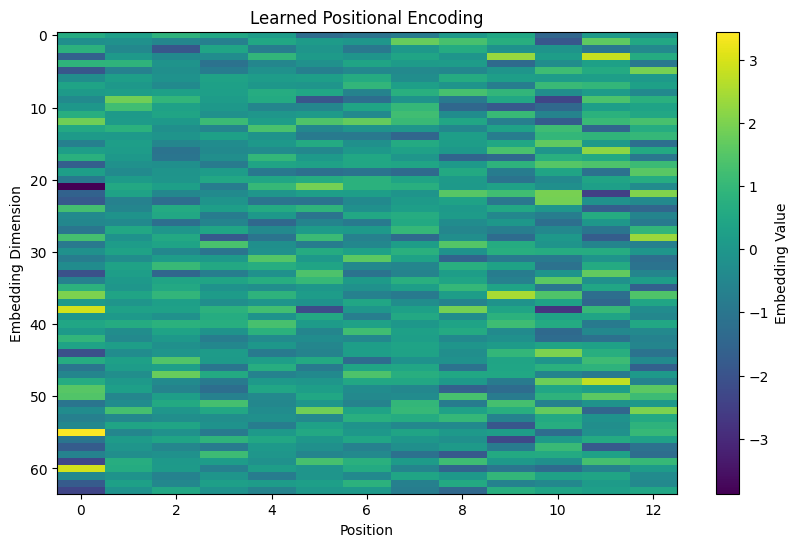

In [66]:
visualize_learned_positional_encoding(learn_p_rnn_encoder)

| **Aspect**                            | **Sine-Cosine (Fixed)**                                     | **Trainable Positional Encoding**                          |
|--------------------------------------|--------------------------------------------------------------|-------------------------------------------------------------|
| **Inductive Bias**                   | Strong, encodes absolute & relative positions                | None                                                        |
| **Generalization to Long Sequences** | Good                                                         | Poor                                                        |
| **Flexibility / Adaptability**       | Low (not task-specific)                                      | High (learns from data)                                     |
| **Parameters Added**                 | None                                                         | Yes (learnable weights)                                     |
| **Risk of Overfitting**              | Low                                                          | Higher (especially on small datasets)                       |
| **Performance on Fixed-Length Data** | May underperform                                             | Often better                                                |
| **Use in Transformers / RNNs**       | Common in vanilla Transformer models                         | Used in some variants and practical implementations         |


### Multi-head Attention Machine Translation

In [213]:
train_ds = NameTranslationDataset(train_df['EnEncoded'].tolist(), train_df['RuEncoded'].tolist())
valid_ds = NameTranslationDataset(valid_df['EnEncoded'].tolist(), valid_df['RuEncoded'].tolist())
test_ds = NameTranslationDataset(test_df['EnEncoded'].tolist(), test_df['RuEncoded'].tolist())

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True)
valid_loader = DataLoader(valid_ds, batch_size=128)
test_loader = DataLoader(test_ds, batch_size=128)

In [214]:
class MultiHeadAttention(nn.Module):
    def __init__(self, embed_dim, n_heads):
        super().__init__()
        assert embed_dim % n_heads == 0, "Embedding dimension must be divisible by number of heads"
        self.n_heads = n_heads
        self.head_dim = embed_dim // n_heads

        self.q_linear = nn.Linear(embed_dim, embed_dim)
        self.k_linear = nn.Linear(embed_dim, embed_dim)
        self.v_linear = nn.Linear(embed_dim, embed_dim)
        self.out_linear = nn.Linear(embed_dim, embed_dim)

    def forward(self, q, k, v, mask=None):
        batch_size = q.size(0)

        # Linear projections
        Q = self.q_linear(q)  # (batch, seq_len, embed_dim)
        K = self.k_linear(k)
        V = self.v_linear(v)

        # Split into heads
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).transpose(1,2)  # (batch, heads, seq_len, head_dim)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).transpose(1,2)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).transpose(1,2)

        # Scaled dot-product attention
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.head_dim)  # (batch, heads, seq_len_q, seq_len_k)
        if mask is not None:
            scores = scores.masked_fill(mask == 0, float('-inf'))
        attn_weights = torch.softmax(scores, dim=-1)  # Attention matrix per head

        attn_output = torch.matmul(attn_weights, V)  # (batch, heads, seq_len_q, head_dim)

        # Concatenate heads and pass through output linear layer
        attn_output = attn_output.transpose(1, 2).contiguous().view(batch_size, -1, self.n_heads * self.head_dim)
        output = self.out_linear(attn_output)

        return output, attn_weights  # Return attention weights for visualization

In [215]:
class MultiHeadAttentionDecoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, pad_idx, n_heads=3, max_len=100):
        super().__init__()
        assert hidden_dim % n_heads == 0, "hidden_dim must be divisible by n_heads"

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        self.register_buffer('pos_encoding', get_positional_encoding(max_len, embedding_dim).unsqueeze(0))
        self.attn = MultiHeadAttention(hidden_dim, n_heads)
        self.gru = nn.GRU(embedding_dim + hidden_dim, hidden_dim, batch_first=True)
        self.fc_out = nn.Linear(hidden_dim, vocab_size)

    def forward(self, y_input, encoder_outputs, hidden, mask=None):
        B, T = y_input.shape

        embedded = self.embedding(y_input)  # (B, T, embedding_dim)

        # Repeat hidden state as query
        query = hidden[-1].unsqueeze(1).repeat(1, T, 1)  # (B, T, hidden_dim)

        # Attention
        attn_output, attn_weights = self.attn(query, encoder_outputs, encoder_outputs, mask=mask)  # (B, T, hidden_dim)

        # Concatenate and run through GRU
        gru_input = torch.cat([embedded, attn_output], dim=-1)  # (B, T, embedding_dim + hidden_dim)
        output, hidden = self.gru(gru_input, hidden)  # output: (B, T, hidden_dim)

        logits = self.fc_out(output)  # (B, T, vocab_size)
        return logits, hidden, attn_weights

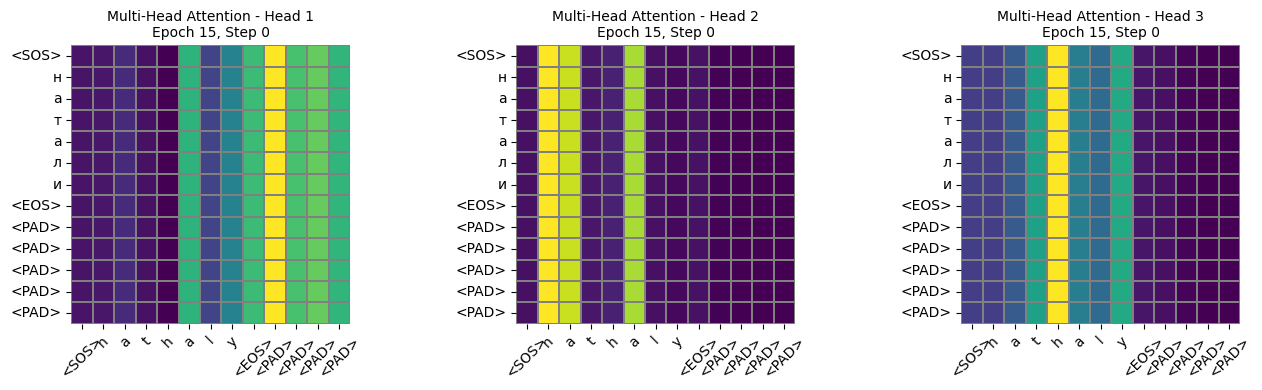

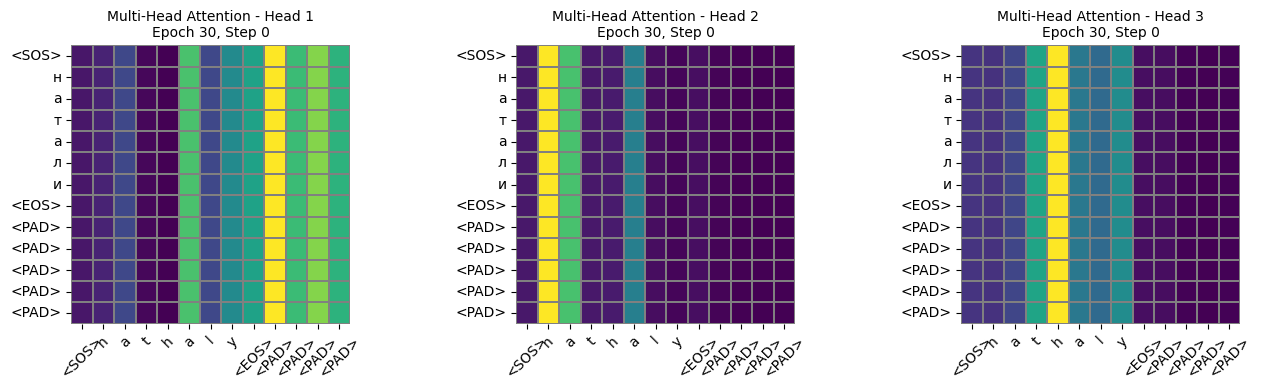

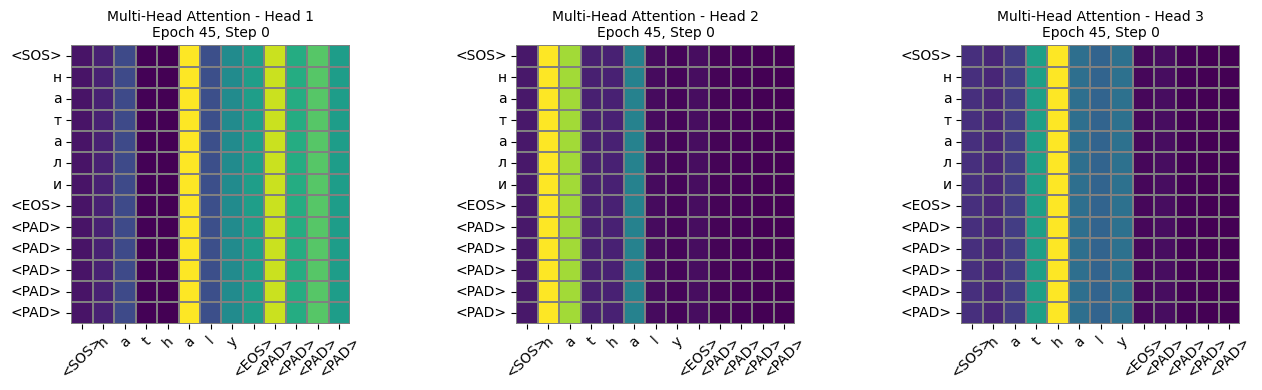

Early stopping triggered at epoch 45


In [216]:
attn_decoder = MultiHeadAttentionDecoder(
    vocab_size=RU_VOCAB_SIZE,
    embedding_dim=64,
    hidden_dim=96,  # match encoder
    pad_idx=RU_PAD_IDX,
    n_heads=3,
    max_len=MAX_RU_LEN
).to(device)

optimizer = torch.optim.Adam(attn_decoder.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(ignore_index=RU_PAD_IDX)
early_stopping = EarlyStopping(patience=7, min_delta=0.001)

fixed_plot_loader = DataLoader(train_loader.dataset, batch_size=128, shuffle=False)

train_losses, valid_losses = train_mha_model(
    encoder=p_rnn_encoder,
    decoder=attn_decoder,
    train_loader=train_loader,
    valid_loader=valid_loader,
    criterion=criterion,
    optimizer=optimizer,
    early_stopping=early_stopping,
    src_id2token=EN_ID2TOKEN,
    tgt_id2token=RU_ID2TOKEN,
    n_epochs=100,
    name="Multi-Head Attention",
    fixed_plot_loader=fixed_plot_loader,
    plot_sample_index=15
)

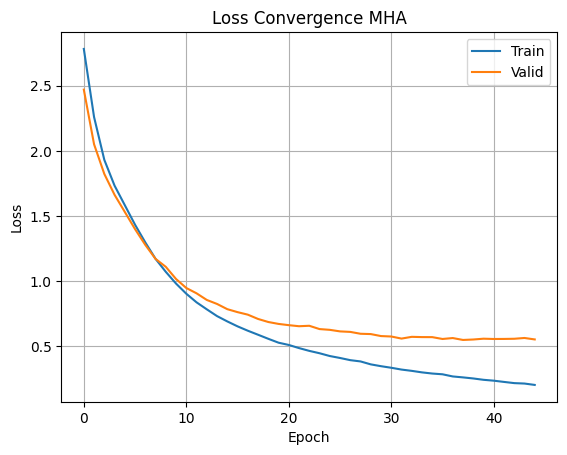

In [217]:
plot_loss_curves(train_losses, valid_losses, title='MHA')

In [223]:
print_sample_translations(train_df, p_rnn_encoder, attn_decoder, use_attention=True, name="Train (Attention + PE)")
print_sample_translations(valid_df, p_rnn_encoder, attn_decoder, use_attention=True, name="Valid (Attention + PE)")


Train (Attention + PE) Sample Translations:
Adalberto → Адабеларто (true: Адальберто)
Zackary → Закарио (true: Закари)
Leah → Лиан (true: Лия)
Zayne → Зайн (true: Зейн)
Hazle → Хейзель (true: Хейзел)

Valid (Attention + PE) Sample Translations:
Candido → Каддион (true: Кандидо)
Cruz → Кёрк (true: Круз)
Carlee → Карлио (true: Карли)
Merrie → Мерис (true: Мерри)
Jasen → Дасейс (true: Джейсен)


In [218]:
evaluate_test_perplexity(p_rnn_encoder, attn_decoder, test_loader, criterion, use_attention=True)

Test Loss: 0.6254 | Perplexity: 1.87


In sequence-to-sequence models with attention, the decoder generates tokens step-by-step. At decoder timestep t, the decoder input is actually the token from timestep t-1 of the target sequence (this is called teacher forcing — the input is shifted right by one).

Because of this, when the decoder is predicting the token at position t, it focuses its attention mostly on the encoder token at position t-1. This creates an attention matrix where the strongest weights lie along a diagonal that is shifted by one position.

So the “shifted diagonal” means the decoder aligns each output token with the previous input token, which helps the model learn to produce the next token based on the right part of the input sequence.

This pattern is expected and shows the model has learned a good alignment between input and output sequences.

### Bonus Part

In [224]:
def get_ngrams(sequence, n):
    """
    Extract all n-grams of length n from the input sequence (string).
    Example: "cat", n=2 -> ["ca", "at"]
    """
    return [sequence[i:i+n] for i in range(len(sequence)-n+1)]

In [ ]:
def clipped_precision(candidate, reference, n):
    """
    Calculate clipped precision for n-grams of order n.
    Arguments:
    - candidate: predicted string
    - reference: ground truth string

    Steps:
    1. Extract n-grams from candidate and reference.
    2. Count occurrences of each n-gram in both.
    3. Clip candidate counts by max counts in reference.
    4. Return clipped count sum / total candidate n-grams.
    """
    cand_ngrams = get_ngrams(candidate, n)
    ref_ngrams = get_ngrams(reference, n)

    cand_counts = Counter(cand_ngrams)
    ref_counts = Counter(ref_ngrams)

    # Clip candidate counts by reference counts to avoid rewarding repeated n-grams more than in ref
    clipped_counts = {ng: min(count, ref_counts.get(ng, 0)) for ng, count in cand_counts.items()}

    clipped_total = sum(clipped_counts.values())
    total = len(cand_ngrams)

    if total == 0:
        return 0

    return clipped_total / total

In [226]:
def brevity_penalty(candidate, reference):
    """
    Calculate brevity penalty to penalize too short translations.
    c = length of candidate, r = length of reference.
    """
    c = len(candidate)
    r = len(reference)

    if c > r:
        return 1
    elif c == 0:
        return 0
    else:
        return math.exp(1 - r / c)

In [227]:
def bleu_score(candidate, reference, max_n=4):
    """
    Calculate BLEU score up to max_n-grams.
    Steps:
    - Compute clipped precision for n=1,...,max_n
    - Compute geometric mean of precisions (with log and exp)
    - Apply brevity penalty
    """
    precisions = []
    for n in range(1, max_n+1):
        p = clipped_precision(candidate, reference, n)
        if p == 0:
            # Avoid log(0) by using small value
            precisions.append(1e-7)
        else:
            precisions.append(p)
    log_prec = sum(math.log(p) for p in precisions) / max_n
    bp = brevity_penalty(candidate, reference)
    return bp * math.exp(log_prec)

BLEU просто сравнивает похожесть двух последовательностей

In [229]:
candidate1 = "мария"
reference1 = "мария"

candidate2 = "мария"
reference2 = "марина"

candidate3 = "маша"
reference3 = "мария"

print("BLEU(candidate1, reference1):", bleu_score(candidate1, reference1))
print("BLEU(candidate2, reference2):", bleu_score(candidate2, reference2))
print("BLEU(candidate3, reference3):", bleu_score(candidate3, reference3))

BLEU(candidate1, reference1): 1.0
BLEU(candidate2, reference2): 0.5475182535069453
BLEU(candidate3, reference3): 0.00015735790572500688
